In [1]:
#imports 
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import json
from sentence_transformers import SentenceTransformer
from sklearn.manifold import TSNE
import os

/home/guillaumelevy/Documents/WorldLLM/.venv/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [2]:
#Load the data
extension = "_wt5"
print(f"-------------------------------- Load MH {extension} --------------------------------")
name_experiment = "playground_metropolis_phi_phi" + extension
path_start = "./outputs/" + name_experiment + "/"
lst_data = []             
for f_day in os.listdir(path_start):
    if os.path.isdir(path_start + f_day):
        for f_hour in os.listdir(path_start + f_day):
            if os.path.isdir(path_start + f_day + "/" + f_hour):
                path = path_start + f_day + "/" + f_hour + "/all.json"
                with open(path, "r") as file:
                    lst_data.append(json.load(file))
                    print("Loaded: " + path)

-------------------------------- Load MH _wt5 --------------------------------
Loaded: ./outputs/playground_metropolis_phi_phi_wt5/2024-09-11/17-52-41_438/all.json
Loaded: ./outputs/playground_metropolis_phi_phi_wt5/2024-09-11/17-52-38_439/all.json


In [3]:
# Reconstruct all rules MH
all_rules = []
all_likelihoods = []
all_weights = []
all_prev_rules_ind = []
for data in lst_data:
    nb_particles = data["metrics"]["nb_particles"]
    rules = np.array(data["rules"])
    likelihoods = np.array(data["likelihoods"])
    weights =  np.array(data["metrics"]["weights"])
    prev_rules_ind = np.array(data["metrics"]["prev_rules_ind"])
    all_rules.append(rules.reshape((-1, nb_particles)).transpose())
    all_likelihoods.append(likelihoods.reshape((-1, nb_particles)).transpose())
    all_weights.append(weights.reshape((-1, nb_particles)).transpose())
    all_prev_rules_ind.append(prev_rules_ind.reshape((-1, nb_particles)).transpose())
# Concatenate all seeds
all_rules = np.concatenate(all_rules, axis=0)
all_likelihoods = np.concatenate(all_likelihoods, axis=0)
all_weights = np.concatenate(all_weights, axis=0)
all_prev_rules_ind = np.concatenate(all_prev_rules_ind, axis=0)

# Print rules

In [4]:
# Compare best rule for MH
# Best rules for each seed
best_taken = 1000
best_rules_ind_seed = np.argsort(-all_likelihoods, axis=1)[:,:best_taken]
best_rules = np.take_along_axis(all_rules, best_rules_ind_seed, axis=1)
best_likelihoods = np.take_along_axis(all_likelihoods, best_rules_ind_seed, axis=1)
best_rules_ind = np.argsort(-best_likelihoods.flatten())
for incr, ind in enumerate(best_rules_ind):
    seed = ind % all_rules.shape[0]
    unravel_ind = np.unravel_index(ind, best_rules.shape)
    print(
        f"-----rule-----:{incr}({seed}): {repr(best_rules[unravel_ind])}, likelihood: {best_likelihoods[unravel_ind]:2f}"
    )

-----rule-----:0(0): '1. Objects or animals cannot grow into more than one mature form.\n2. Holding a water or seed allows the corresponding plant (berry, pea, potato, etc.) to grow into the corresponding animal (berry, pea, potato, etc.).\n3. Once an object or animal has grown, it cannot be developed further by holding another object or animal.\n4. You can hold only one object or animal at a time.', likelihood: -292.778168
-----rule-----:1(3): '1. Water doubles any object or animal when used.\n2. Seeds grow into the organism of the same kind when visited (e.g., pea seeds into peas).\n3. Smaller or younger individuals grow into larger or older ones when interacting (e.g., baby giraffes growing into giraffes).\n4. Objects or animals can be visited only once in a single trail to add one more.\n5. Repeated visits to the same seed growing into the same organism imply its frequent availability in the environment.\n6. Repeated visits to the same type of seed result in identical seeds growing

# Individual Analysis

## Metropolis Hasting analysis


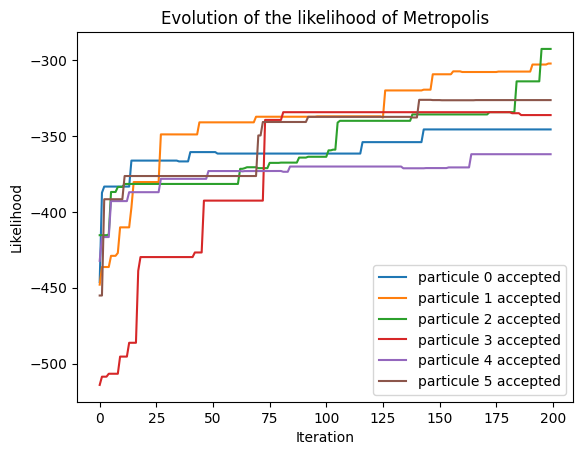

In [5]:
plt.figure()
for seed in range(all_rules.shape[0]):
    plt.plot(all_likelihoods[seed,all_prev_rules_ind[seed,1:]], label="particule "+ str(seed)+" accepted")
plt.xlabel("Iteration")
plt.ylabel("Likelihood")
plt.legend()
plt.title("Evolution of the likelihood of Metropolis")
plt.show()


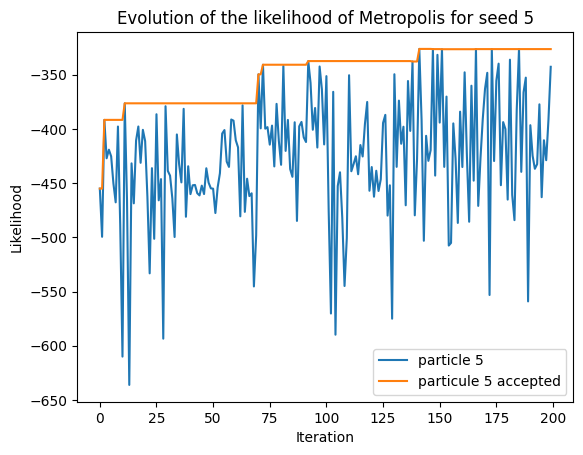

In [16]:
seed = 5
plt.figure()
plt.plot(all_likelihoods[seed, :-1], label="particle "+ str(seed))
plt.plot(all_likelihoods[seed,all_prev_rules_ind[seed,1:]], label="particule "+ str(seed)+" accepted")
plt.xlabel("Iteration")
plt.ylabel("Likelihood")
plt.legend()
plt.title("Evolution of the likelihood of Metropolis for seed " + str(seed))
plt.show()


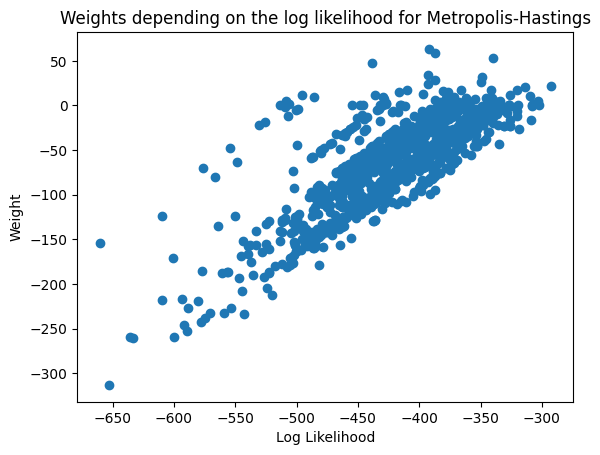

In [7]:
# Evolution of the weights depending on the likelihood
plt.figure()
plt.scatter(all_likelihoods.flatten(), all_weights.flatten())
plt.xlabel("Log Likelihood")
plt.ylabel("Weight")
plt.title("Weights depending on the log likelihood for Metropolis-Hastings")
plt.show()


Text(0.5, 1.0, 'Weights depending on the log likelihood difference')

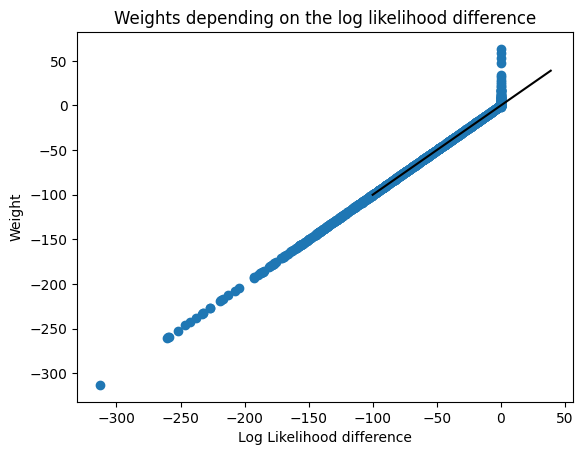

In [8]:
#Compute difference between rule and previous rule
# Find the position of the gloabl array given the branch and branch index
_index = np.arange(all_likelihoods.shape[0]).repeat(all_likelihoods.shape[1]-1).reshape((all_likelihoods.shape[0], all_likelihoods.shape[1]-1))
plt.figure()
plt.scatter(all_likelihoods[:,:-1]- all_likelihoods[_index, all_prev_rules_ind[:,1:]], all_weights[:,:-1])
plt.plot(np.arange(-100,40),np.arange(-100,40), color="black")
plt.xlabel("Log Likelihood difference")
plt.ylabel("Weight")
plt.title("Weights depending on the log likelihood difference")

Text(0.5, 1.0, 'Difference of weights depending on the log likelihood difference')

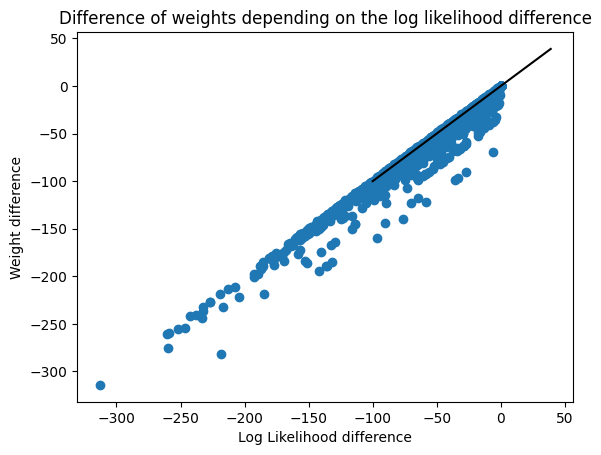

In [9]:
#Compute difference between rule and previous rule
# Find the position of the gloabl array given the branch and branch index
_index = np.arange(all_likelihoods.shape[0]).repeat(all_likelihoods.shape[1]-1).reshape((all_likelihoods.shape[0], all_likelihoods.shape[1]-1))
plt.figure()
plt.scatter(all_likelihoods[:,:-1]- all_likelihoods[_index, all_prev_rules_ind[:,1:]], all_weights[:,:-1] - all_weights[_index, all_prev_rules_ind[:,1:]])
plt.plot(np.arange(-100,40),np.arange(-100,40), color="black")
plt.xlabel("Log Likelihood difference")
plt.ylabel("Weight difference")
plt.title("Difference of weights depending on the log likelihood difference")

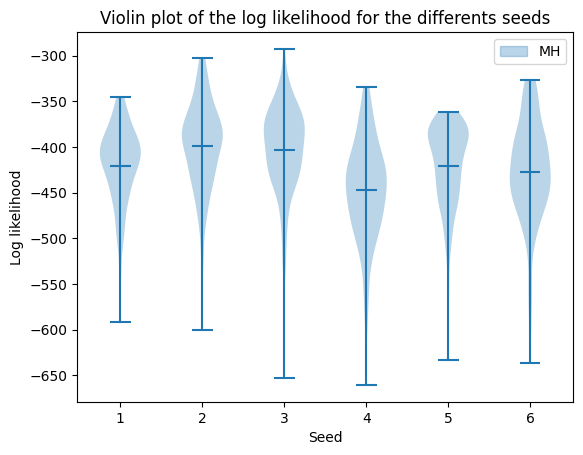

In [10]:
# Plot violin plot of the log likelihood as a function of the seeds for both algorithms
plt.figure()
color_mh = plt.violinplot(all_likelihoods.transpose(), showmeans=True)["bodies"][0].get_facecolor().flatten()
color_mh = matplotlib.patches.Patch(color=color_mh)
plt.legend([color_mh], ["MH"])
plt.title("Violin plot of the log likelihood for the differents seeds")
plt.xlabel("Seed")
plt.ylabel("Log likelihood")
plt.show()